Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [111]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin_Cancer_Data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin_Cancer_Data/Test')

In [112]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2240
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [27]:
batchSize = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [78]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batchSize,
    seed=123)

Found 2240 files belonging to 9 classes.
Using 1792 files for training.


In [79]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batchSize,
    seed=123)

Found 2240 files belonging to 9 classes.
Using 448 files for validation.


In [80]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

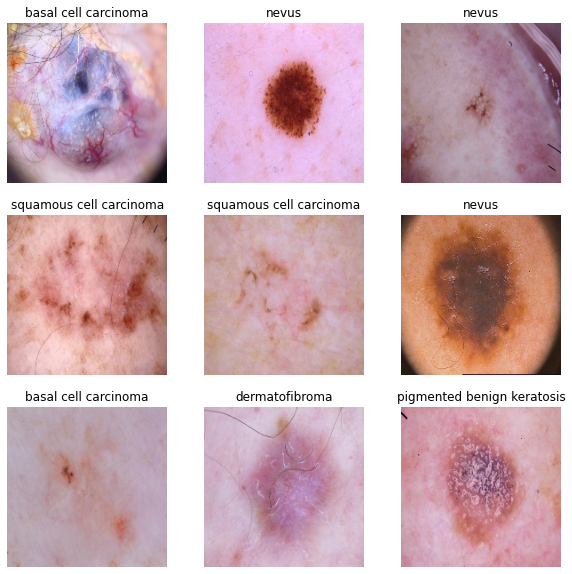

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [81]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### We will now create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [131]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

num_classes = 9
nb_epochs = 25
nb_fc_neurons = 512
nb_filter = 16
nb_conv2d = 3


model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
#first conv layer
model.add(Conv2D(nb_filter, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#second conv layer
model.add(Conv2D(nb_filter*2, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#third conv layer
model.add(Conv2D(nb_filter*4, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#FC layer
model.add(Flatten())
model.add(Dense(nb_fc_neurons))
model.add(Activation('relu'))

#Softmax layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [83]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
activation_35 (Activation)   (None, 178, 178, 16)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
activation_36 (Activation)   (None, 87, 87, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 43, 43, 32)       

### Train the model

In [85]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 91ms/step - loss: 2.0183 - accuracy: 0.2458 - val_loss: 1.6764 - val_accuracy: 0.3906
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5902 - accuracy: 0.4390 - val_loss: 1.4395 - val_accuracy: 0.5112
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4437 - accuracy: 0.4873 - val_loss: 1.4682 - val_accuracy: 0.5045
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3051 - accuracy: 0.5460 - val_loss: 1.3185 - val_accuracy: 0.5558
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1943 - accuracy: 0.5667 - val_loss: 1.2927 - val_accuracy: 0.5692
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.0879 - accuracy: 0.6074 - val_loss: 1.4346 - val_accuracy: 0.5089
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.0315 - accuracy: 0.6243 - val_loss: 1.3670 - val_accuracy: 0.5759
Epoch 8/20
5

### Visualizing training results

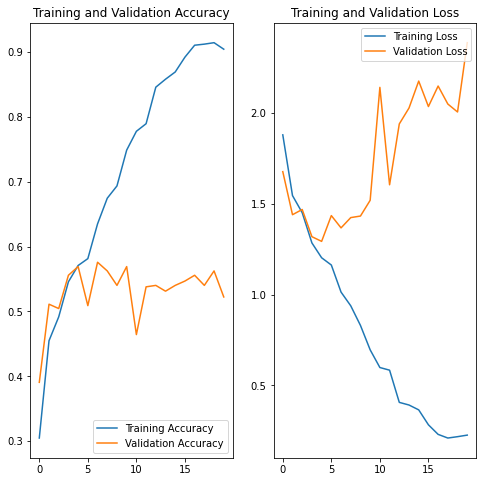

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

* Though we added a dropout layer, the training accuracy and validation accuracy has a huge gap that clearly indicates that the model is overfitting.
* We need to use some augementation strategy to take care of this

### Data Augmentation

* Overfitting generally occurs when there are a small number of training examples.
* Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.

#####This helps expose the model to more aspects of the data and generalize better.

In [96]:
#Creating a data augmentation layer

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1),
     layers.experimental.preprocessing.RandomFlip("vertical", input_shape=input_shape)
     ])

###### Let's visualize the augmentation strategy for one instance of the training image

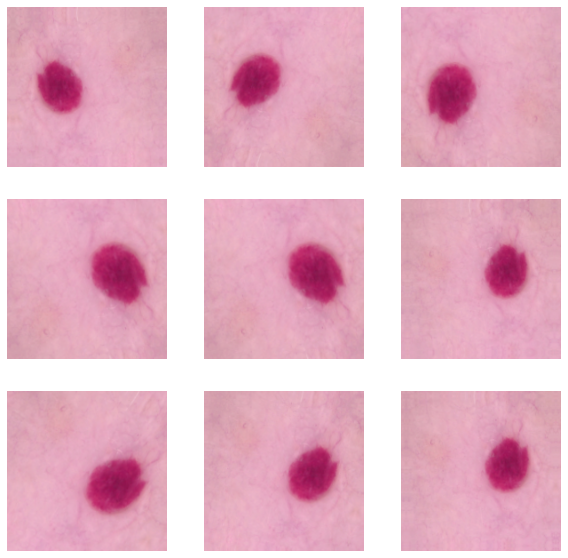

In [97]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Let's create the model with the data augmentation layer


In [132]:
model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
#first conv layer
model.add(Conv2D(nb_filter, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#second conv layer
model.add(Conv2D(nb_filter*2, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#third conv layer
model.add(Conv2D(nb_filter*4, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#FC layer
model.add(Flatten())
model.add(Dense(nb_fc_neurons))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Softmax layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling the model

In [133]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [134]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 43s 240ms/step - loss: 9.7134 - accuracy: 0.2152 - val_loss: 15.8793 - val_accuracy: 0.1209
Epoch 2/20
169/169 [==============================] - 43s 246ms/step - loss: 1.9397 - accuracy: 0.2800 - val_loss: 9.1080 - val_accuracy: 0.1625
Epoch 3/20
169/169 [==============================] - 43s 246ms/step - loss: 1.8509 - accuracy: 0.2998 - val_loss: 5.7829 - val_accuracy: 0.2700
Epoch 4/20
169/169 [==============================] - 43s 246ms/step - loss: 1.7653 - accuracy: 0.3294 - val_loss: 3.8844 - val_accuracy: 0.3731
Epoch 5/20
169/169 [==============================] - 43s 246ms/step - loss: 1.7472 - accuracy: 0.3421 - val_loss: 2.2533 - val_accuracy: 0.3234
Epoch 6/20
169/169 [==============================] - 42s 241ms/step - loss: 1.6784 - accuracy: 0.3695 - val_loss: 2.1868 - val_accuracy: 0.3865
Epoch 7/20
169/169 [==============================] - 42s 241ms/step - loss: 1.7074 - accuracy: 0.3588 - val_loss: 1.9877 - val_a

### Visualizing the results

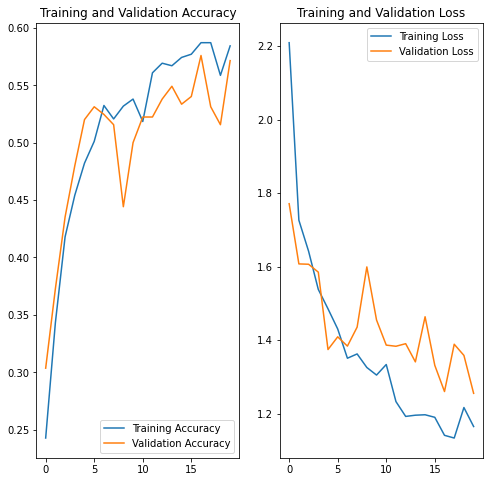

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Clearly, there is drastic improvement in the validation accuracy. Thus, we can see that the data augmentation works well

### <b>Distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
labels = train_ds.class_names

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [93]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [117]:
path_to_training_dataset= str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_top_bottom(probability=0.8)
    p.rotate90(probability=0.1)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE674217D68>: 100%|██████████| 500/500 [00:19<00:00, 25.39 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE674C45A20>: 100%|██████████| 500/500 [00:20<00:00, 24.56 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE674E2A048>: 100%|██████████| 500/500 [00:20<00:00, 24.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE674E4AD30>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FE66CA891D0>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE719129748>:   0%|          | 1/500 [00:00<01:05,  7.67 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE675F9F6A0>: 100%|██████████| 500/500 [00:20<00:00, 24.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE6D4BE9EF0>: 100%|██████████| 500/500 [00:44<00:00, 11.29 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 182 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE66CA49DD8>: 100%|██████████| 500/500 [00:20<00:00, 24.81 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6741C60B8>: 100%|██████████| 500/500 [00:20<00:00, 24.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [118]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [123]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_d92f399f-9cd4-4597-bd74-d1af508e34fe.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_5623f00d-cecc-4e08-9348-31b2931815cf.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_2857f12e-826d-4cc9-a705-dd60d99c2915.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_536d0c66-82c5-4f90-8560-dcc8f1a54ea4.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_b2d65827-6436-414e-b7d5-4be57f509c45.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_46e65557-7ab3-4021-9eef-fc6e1b05fd7d.jpg',
 '/content/gdrive/MyDrive/Skin_Can

In [121]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [128]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [129]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6740 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [130]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6740 files belonging to 9 classes.
Using 1348 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [2]:
model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
#first conv layer
model.add(Conv2D(nb_filter, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#second conv layer
model.add(Conv2D(nb_filter*2, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#third conv layer
model.add(Conv2D(nb_filter*4, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#FC layer
model.add(Flatten())
model.add(Dense(nb_fc_neurons))
model.add(Activation('relu'))

#Softmax layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

NameError: ignored

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [136]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [137]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 239ms/step - loss: 2.1040 - accuracy: 0.2322 - val_loss: 1.6420 - val_accuracy: 0.3494
Epoch 2/30
169/169 [==============================] - 41s 233ms/step - loss: 1.5855 - accuracy: 0.3966 - val_loss: 1.4292 - val_accuracy: 0.4555
Epoch 3/30
169/169 [==============================] - 40s 228ms/step - loss: 1.4442 - accuracy: 0.4477 - val_loss: 1.3742 - val_accuracy: 0.4733
Epoch 4/30
169/169 [==============================] - 39s 226ms/step - loss: 1.3403 - accuracy: 0.4882 - val_loss: 1.4356 - val_accuracy: 0.4711
Epoch 5/30
169/169 [==============================] - 40s 228ms/step - loss: 1.3258 - accuracy: 0.4811 - val_loss: 1.2565 - val_accuracy: 0.5074
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 1.2137 - accuracy: 0.5241 - val_loss: 1.1641 - val_accuracy: 0.5415
Epoch 7/30
169/169 [==============================] - 39s 223ms/step - loss: 1.1735 - accuracy: 0.5492 - val_loss: 1.1422 - val_ac

#### **Todo:**  Visualize the model results

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

